# Investigating pricing anomaly in Dual-Listed Stocks

here we load in the data from goog and googl and investigate the price discrepancy

In [1]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import matplotlib.dates as mdates
import alpaca_trade_api as tradeapi

In [2]:
load_dotenv()
API_KEY = os.getenv('API_KEY')
SECRET_KEY = os.getenv('SECRET_KEY')
BASE_URL = os.getenv('BASE_URL')
api = tradeapi.REST(API_KEY, SECRET_KEY, BASE_URL, api_version='v2')

In [3]:
def fetch_data(symbol, timeframe, start, end):
    barset = api.get_bars(symbol, timeframe, start, end)
    return barset 

In [18]:
TICKER_PAIRS = (('GOOGL', 'GOOG'), 
                ('BF.A', 'BF.B'), 
                ('FOXA', 'FOX'), 
                ('FWONA', 'FWONk'), 
                ('NWSA', 'NWS'), 
                ('UAA', 'UA'))

In [28]:
timeframe = '15Min' # Desired time resolution of data

symbolA = TICKER_PAIRS[0][0]  # Class A shares have voting rights 
symbolC = TICKER_PAIRS[0][1]   # Class C do not

start_date = datetime(2024, 3, 1)
end_date = datetime(2024, 7, 5)  # Adjust the end date as needed

# populating inputs for data fetch
end_date = end_date.isoformat() + 'Z' 
start_date = start_date.isoformat() + 'Z' 

barsetA = fetch_data(symbolA, timeframe, start_date, end_date)
barsetC = fetch_data(symbolC, timeframe, start_date, end_date)

In [29]:
dfA = pd.DataFrame({
    'time': [bar.t for bar in barsetA],
    'A\'s open': [bar.o for bar in barsetA],
    'A\'s high': [bar.h for bar in barsetA],
    'A\'s low': [bar.l for bar in barsetA],
    'A\'s close': [bar.c for bar in barsetA],
    'A\'s volume': [bar.v for bar in barsetA],
})
dfC = pd.DataFrame({
    'time': [bar.t for bar in barsetC],
    'C\'s open': [bar.o for bar in barsetC],
    'C\'s high': [bar.h for bar in barsetC],
    'C\'s low': [bar.l for bar in barsetC],
    'C\'s close': [bar.c for bar in barsetC],
    'C\'s volume': [bar.v for bar in barsetC],
})
merged_df = pd.merge(dfA, dfC, on='time', how='inner')
merged_df.shape

(5106, 11)

In [30]:
mean_premium = (np.average(merged_df['A\'s high'] + merged_df['A\'s low']) - np.average(merged_df['C\'s high'] + merged_df['C\'s low'])) * 100 / np.average(merged_df['C\'s high'] + merged_df['C\'s low'])
merged_df['Percent premium for votes'] = ((merged_df['A\'s high'] + merged_df['A\'s low'])/2 - (merged_df['C\'s high'] + merged_df['C\'s low'])/2) * 100 / ((merged_df['C\'s high'] + merged_df['C\'s low'])/2)
merged_df['SMA_6hr'] = merged_df['Percent premium for votes'].rolling(window=24).mean()
merged_df['SMA_2wk'] = merged_df['Percent premium for votes'].rolling(window=700).mean()
merged_df

,time,A's open,A's high,A's low,A's close,A's volume,C's open,C's high,C's low,C's close,C's volume,Percent premium for votes,SMA_6hr,SMA_2wk
0,2024-02-29 19:00:00-05:00,138.0900,138.1100,138.0500,138.1100,3252,139.3200,139.4300,139.3000,139.4300,1928,-0.922039,NaN,NaN
1,2024-02-29 19:15:00-05:00,138.1400,139.0000,138.1400,138.3200,45590,139.5000,139.7400,139.5000,139.6900,9167,-0.752041,NaN,NaN
2,2024-02-29 19:30:00-05:00,138.3100,138.3200,138.1100,138.1400,3222,139.6000,139.7000,139.4400,139.4400,1833,-0.970839,NaN,NaN
3,2024-02-29 19:45:00-05:00,138.2000,138.3000,138.1800,138.1800,909,139.5900,139.6000,139.4400,139.4400,6534,-0.917431,NaN,NaN
4,2024-03-01 04:00:00-05:00,138.6000,138.9200,138.6000,138.7700,4708,140.0200,140.2600,140.0100,140.0400,3263,-0.981197,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5101,2024-07-03 15:00:00-04:00,185.7300,185.7300,185.7300,185.7300,184,187.1847,187.1847,187.1847,187.1847,101,-0.777147,-0.763416,-0.813720
5102,2024-07-03 15:30:00-04:00,185.7200,185.7200,185.6501,185.6501,721,187.2500,187.2500,187.2500,187.2500,593,-0.835754,-0.766021,-0.813573
5103,2024-07-03 15:45:00-04:00,185.6900,185.7799,185.4200,185.7100,3670,187.1100,187.2500,187.0000,187.0000,2570,-0.814990,-0.769218,-0.813398
5104,2024-07-03 16:30:00-04:00,185.7476,185.7476,185.6418,185.6418,601,187.1900,187.1900,187.1900,187.1900,105,-0.798814,-0.770688,-0.813193


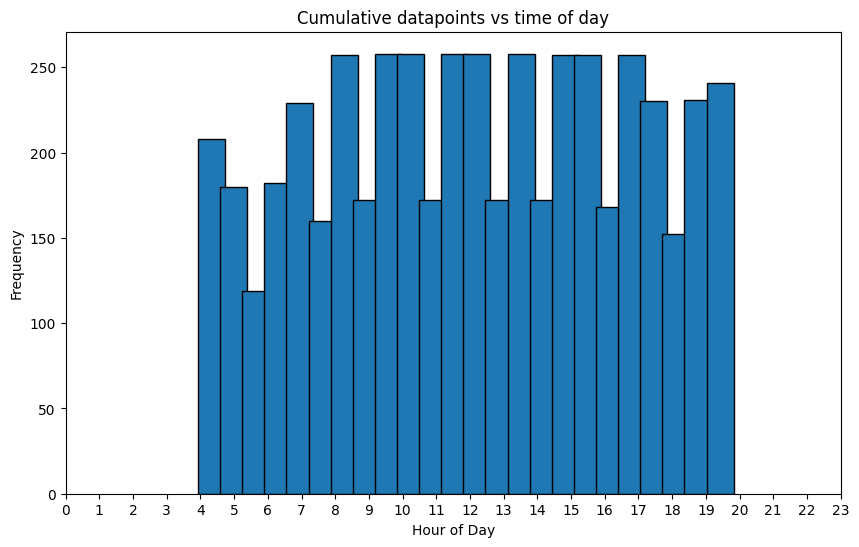

In [31]:
"""
This cell briefly checks from what times our call is returning data
"""

# Convert time to datetime
merged_df['time'] = pd.to_datetime(merged_df['time'])

# Extract hour from time
merged_df['hour'] = merged_df['time'].dt.hour + merged_df['time'].dt.minute / 60

# Plot density of times
plt.figure(figsize=(10, 6))

# Use binned_statistic to get density values
statistic, bin_edges, _ = binned_statistic(merged_df['hour'], merged_df['hour'], statistic='count', bins=24)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.bar(bin_centers, statistic, width=0.8, align='center', edgecolor='k')

plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Cumulative datapoints vs time of day')
plt.xticks(range(0, 24))

plt.show()

In [32]:
merged_df = merged_df.tail(1500)

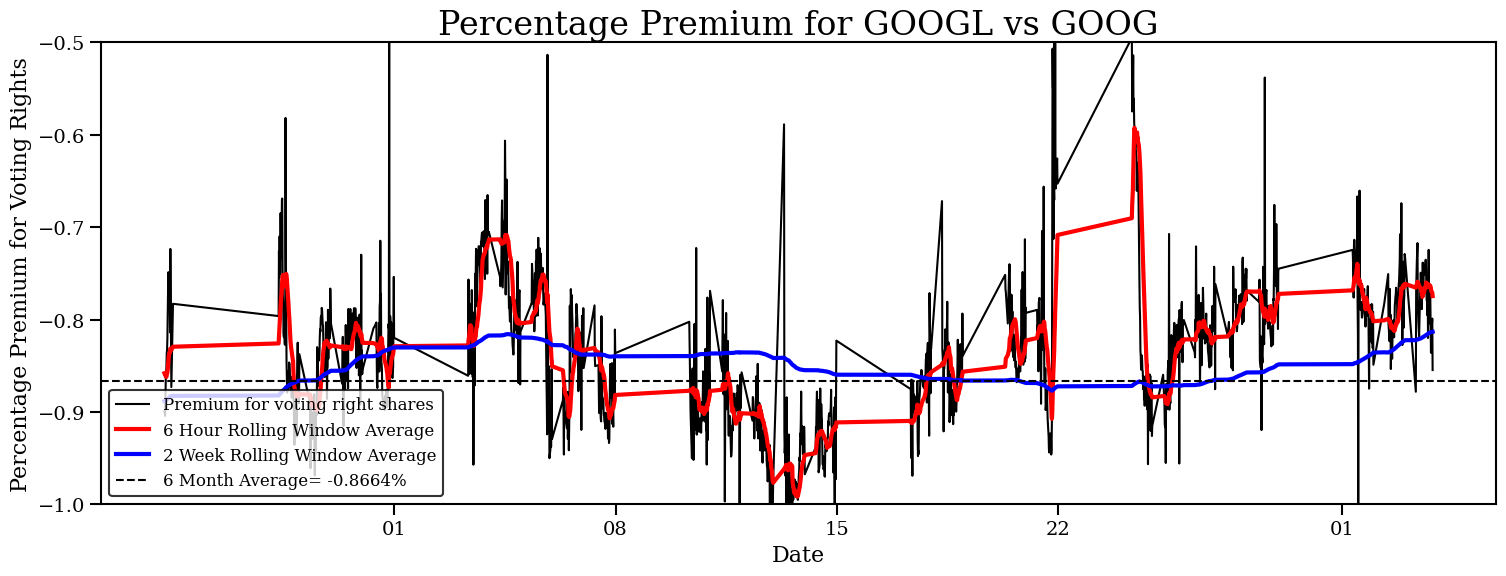

In [34]:
fig, ax = plt.subplots(figsize=(18, 6))  
ax.plot(merged_df['time'], merged_df['Percent premium for votes'], label = 'Premium for voting right shares', color = 'black')
ax.plot(merged_df['time'], merged_df['SMA_6hr'], label = '6 Hour Rolling Window Average', color = 'red', linewidth = 3)
ax.plot(merged_df['time'], merged_df['SMA_2wk'], label = '2 Week Rolling Window Average', color = 'blue', linewidth = 3)


ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

# Set labels and title
plt.xlabel('Date', font = 'serif', fontsize = 16)
plt.ylabel('Percentage Premium for Voting Rights', font = 'serif', fontsize = 16)
plt.title(f'Percentage Premium for {symbolA} vs {symbolC}', font = 'serif', fontsize = 24)
plt.axhline(y = mean_premium, linestyle = '--', color = 'black', label = f'6 Month Average= {round(mean_premium, 4)}%')
plt.axhline(y = 0, linestyle = '-',  color = 'black', alpha = 0.5)

# Some very optional formatting
ax.spines['top'].set_linewidth(1.5)
ax.spines['right'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['left'].set_linewidth(1.5)

legend = plt.legend(loc='lower left', prop={'family': 'serif', 'size': 12}, fontsize=12, framealpha = 0.8)
frame = legend.get_frame()
frame.set_edgecolor('black')
frame.set_linewidth(1.5)

# Tickmark formatting
#plt.yticks([-2, -1, 0, 1], font = 'serif', fontsize = 10)

ax.tick_params(axis='y', which='major', width=1.5, length=8)
ax.tick_params(axis='x', which='major', width=1.5, length=8)

plt.yticks(font = 'serif', fontsize = 14)
plt.xticks(font = 'serif', fontsize = 14)
plt.ylim(-1, -0.5)
plt.savefig('Example_SMA_crossing.png', dpi = 400, bbox_inches = 'tight')
plt.show()